- informacion de 4khz en unipolar
- Seno de 4 Mhz y 41-MHZ
- Switche cada 0 o 1
- mandarla al canal
- amplificar, filtrar con pasa banda ideal centrado en 4Mhz y 4.1Mhz con ancho de banda de 60khz 
- Logica para deteccion de 0 o 1

# Adaptar Audio


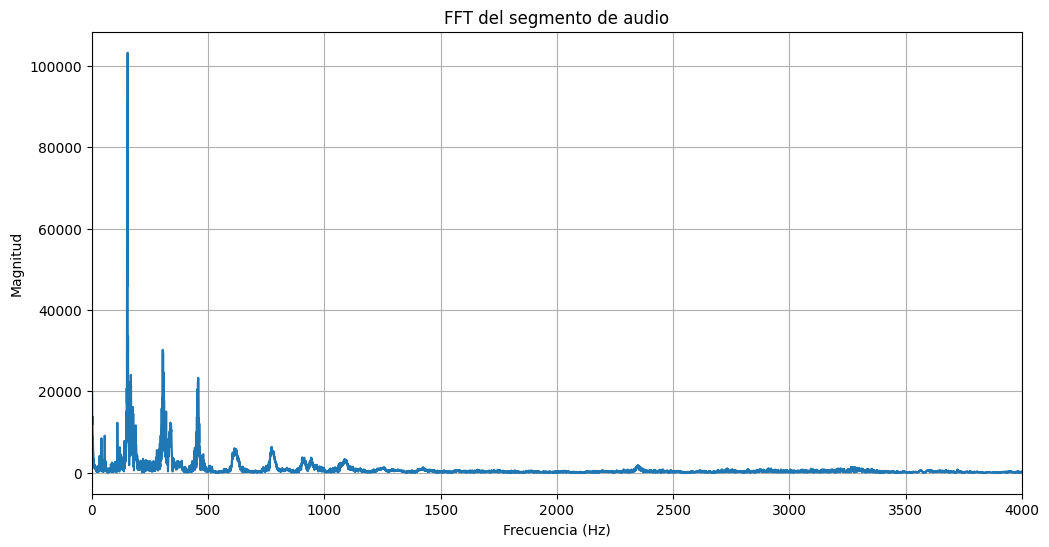

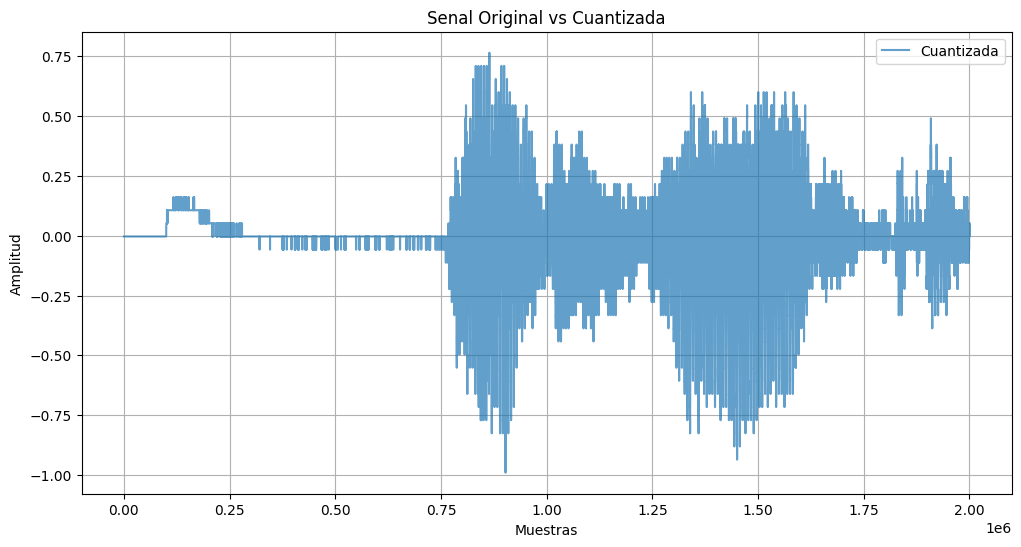

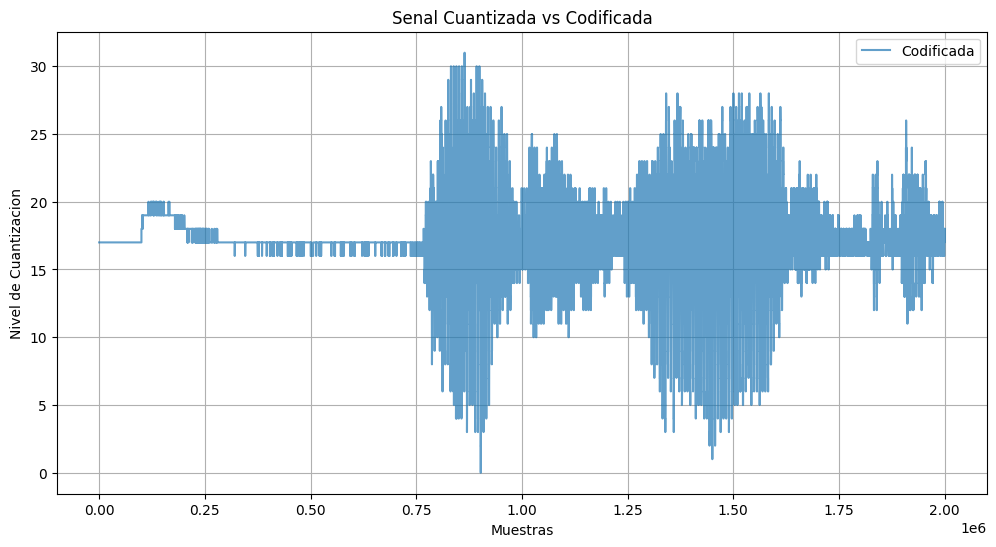

2000000
24000000


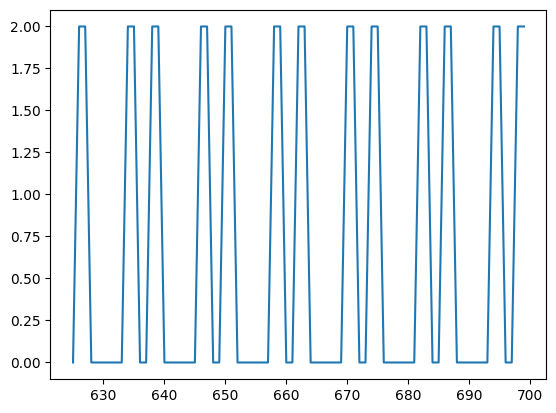

In [15]:
import scipy.io.wavfile as wav
import urllib.request
import io
import IPython.display as ipd
from scipy.io.wavfile import read
from io import BytesIO
from IPython.display import Audio, display
import numpy, scipy.special, scipy.stats
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
# funcion para aplicacion de transformada de Fourier a senoidal
def aplicar_fft(x, fs):
    N = len(x)
    X = numpy.fft.fft(x)
    X = numpy.fft.fftshift(X)  # centrar la FFT
    f = numpy.fft.fftfreq(N, 1/fs)
    f = numpy.fft.fftshift(f)  # centrar las frecuencias
    return f, X
url = "https://raw.githubusercontent.com/jbcgames/Laboratorio_1_Procesamiento/refs/heads/main/Grabaci%C3%B3n.wav"
with urllib.request.urlopen(url) as response:
    wav_data = response.read()
buffer = BytesIO(wav_data)

fs, data = read(buffer)
# 2. Si es estéreo, usar solo un canal
if data.ndim > 1:
    data = data[:, 0]

segment = data
segment = segment / numpy.max(numpy.abs(segment))

#cambiar frecuencia de muestreo
new_fs = 1e6
num_samples = int(len(segment) * new_fs / fs)
segment = scipy.signal.resample(segment, num_samples)
fs = new_fs

# Filtrar a 4khz
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
cutoff = 4000  # frecuencia de corte en Hz
segment = lowpass_filter(segment, cutoff, fs, order=6)
# Cortar a 2 segundos
segment = segment[:int(2 * fs)]
# 4. Reproducir el segmento de audio
temp_fs = 1e4
num_samples = int(len(segment) * temp_fs / fs)
temp_segment = scipy.signal.resample(segment, num_samples)
display(Audio(temp_segment, rate=temp_fs))
t = numpy.arange(0, 0.001, 1/fs)
# graficar FFT del audio
f, X = aplicar_fft(segment, fs)
plt.figure(figsize=(12, 6))
plt.plot(f, numpy.abs(X))
plt.title('FFT del segmento de audio')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(0, 4000)  # Mostrar solo frecuencias positivas
plt.grid()
plt.show()

# Cuantizar la senal
def cuantizar_senal(x, num_bits):
    x_min = numpy.min(x)
    x_max = numpy.max(x)
    q_levels = 2 ** num_bits
    q_step = (x_max - x_min) / q_levels
    x_q = numpy.round((x - x_min) / q_step) * q_step + x_min
    return x_q
num_bits = 5
segment_cuantizada = cuantizar_senal(segment, num_bits)
# graficar senal original y cuantizada
plt.figure(figsize=(12, 6))
#plt.plot(segment, label='Original')
plt.plot(segment_cuantizada, label='Cuantizada', alpha=0.7)
plt.title('Senal Original vs Cuantizada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

#Reproduccion Audio
temp_fs = 1e4
num_samples = int(len(segment_cuantizada) * temp_fs / fs)
temp_segment = scipy.signal.resample(segment_cuantizada, num_samples)
display(Audio(temp_segment, rate=temp_fs))

# Codificar la senal cuantizada en unipolar
def codificar_unipolar(x, num_bits):
    x_min = numpy.min(x)
    x_max = numpy.max(x)
    q_levels = 2 ** num_bits
    x_normalized = (x - x_min) / (x_max - x_min)
    x_scaled = numpy.round(x_normalized * (q_levels - 1))
    return x_scaled
segment_codificada = codificar_unipolar(segment_cuantizada, num_bits)
# graficar senal cuantizada y codificada
plt.figure(figsize=(12, 6))
#plt.plot(segment_cuantizada, label='Cuantizada')
plt.step(range(len(segment_codificada)), segment_codificada, label='Codificada', alpha=0.7)
plt.title('Senal Cuantizada vs Codificada')
plt.xlabel('Muestras')
plt.ylabel('Nivel de Cuantizacion')
plt.legend()
plt.grid()
plt.show()

def codificacion_unipolar(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(int(val), width=num_bits) for val in x_cuantizada]
    # Codificacion unipolar
    x_unipolar = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_unipolar.append(2)
                x_unipolar.append(2)
            else:
                x_unipolar.append(0)
                x_unipolar.append(0)
    return x_unipolar
# Codificacion unipolar
x_unipolar = codificacion_unipolar(segment_codificada, num_bits+1)
tiempo_unipolar = numpy.arange(0, len(x_unipolar))  # ajustar el tiempo a la nueva tasa de bits

x_Codificacion= x_unipolar
plt.figure()
print(len(segment_codificada))
print(len(x_Codificacion))
plt.plot(tiempo_unipolar[625:700],x_Codificacion[625:700])
plt.show()

#  Crear Portadora 1 y 2

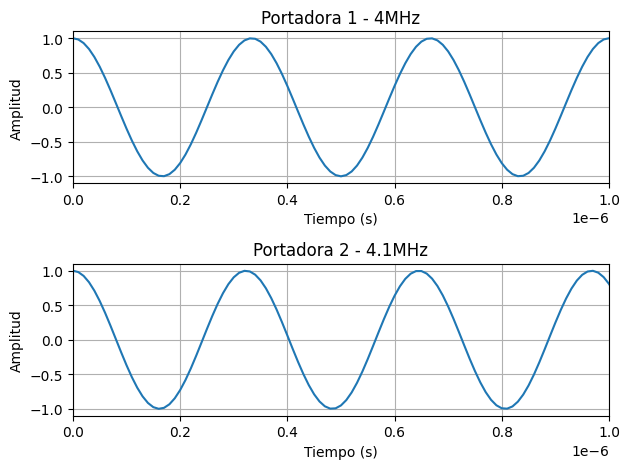

200000000


In [4]:
#generacion de senal de seno de 4mhz
fs = 10e7  # Frecuencia de muestreo
# Duracion del audio 2 segundos
t = numpy.arange(0, 2, 1/fs)

f_seno1 = 3e6
f_seno2 = 3.1e6
A_seno = 1
def señal_cosenoidal(f, A=1):
    x = A * numpy.cos(2 * numpy.pi * f * t )
    return t, x
# Definir fs para coincidir con la informacion
t_1, X_Portadora1 = señal_cosenoidal(f_seno1, A_seno)
t_2, X_Portadora2 = señal_cosenoidal(f_seno2, A_seno)
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t_1, X_Portadora1) 
ax1.set_title('Portadora 1 - 4MHz')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Amplitud')
ax1.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t_2, X_Portadora2)
ax2.set_title('Portadora 2 - 4.1MHz')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Amplitud')
ax2.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
plt.tight_layout()
plt.show()
print(len(X_Portadora1))

# Crear switche

24000000
200000000


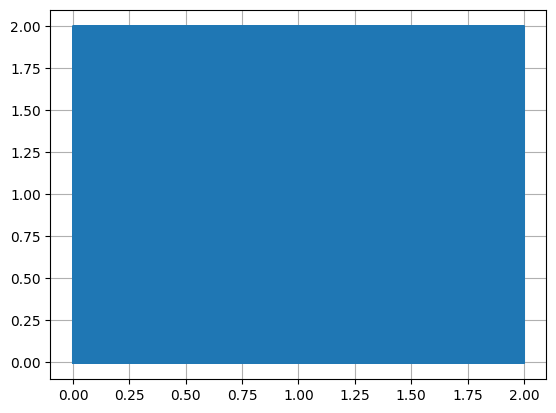

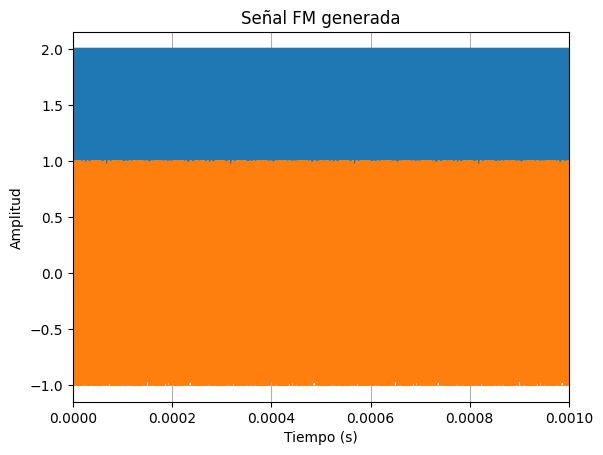

In [26]:
# si 1 entonces portadora 1
# si 0 entonces portadora 2
# Crear switche
def switche(t, x_codificacion, x_portadora1, x_portadora2):
    x_fm = numpy.zeros_like(t)
    for i in range(len(t)):
        if x_codificacion[i] > 0.5:  # umbral para decidir entre 0 y 1
            x_fm[i] = x_portadora1[i]
        else:
            x_fm[i] = x_portadora2[i]
    return x_fm
print(len(x_Codificacion))
print(len(X_Portadora1))
plt.figure()
t = numpy.arange(0, 2, 1/12000000)

plt.plot(t, x_unipolar)
#plt.plot(t_1[:100000], X_Portadora1[:100000])
plt.grid()
#plt.xlim(0, 0.00001)
plt.show()
x_fm = switche(t, x_Codificacion, X_Portadora1, X_Portadora2)

# imprimir la señal
#print(x_fm)
#imprimir el fft de la señal fm
plt.figure()
plt.plot(t_1[:len(x_Codificacion)], x_Codificacion)
plt.plot(t, x_fm)
plt.title('Señal FM generada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim(0, 0.001)
plt.grid()
plt.show()

# Crear Canal

In [ ]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db, snr_db=20):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    # Simular respuesta natural del filtro del canal
    w, h = freqz(b, a, worN=100*32000)
    plt.figure()
    plt.plot((0.16*fs*numpy.pi*w/numpy.pi)/1e6, numpy.abs(h), 'b')
    plt.plot(fc/1e6, 0.5*numpy.sqrt(2), 'ko')
    plt.axvline(fc/1e6, color='k')
    plt.xlim(0, 0.5*fs/1e6)
    plt.title("Respuesta en frecuencia del filtro del canal")
    plt.xlabel('Frecuencia [MHz]')
    plt.ylabel('Ganancia')
    plt.grid()
    plt.show()

    x_filtrada = aplicar_filtro(x, b, a)
    # Atenuacion
    x_ruidos = agregar_ruido_gaussiano(x_filtrada, snr_db)  # SNR de 20 dB
    atenuacion = 10 ** (atenuacion_db / 20)
    X_atenuada = x_ruidos * atenuacion

    return X_atenuada
# Adicion de ruido gaussiano
def agregar_ruido_gaussiano(x, snr_db):
    # Calcular potencia de la señal
    potencia_senal = numpy.mean(x**2)
    # Calcular potencia del ruido
    snr = 10 ** (snr_db / 10)
    potencia_ruido = potencia_senal / snr
    # Generar ruido gaussiano hasta 800 Mhz
    ruido = numpy.random.normal(0, numpy.sqrt(potencia_ruido), len(x))
    # Señal con ruido
    x_ruidosa = x + ruido
    #Graficacion FFT del Ruido
    f, X = aplicar_fft(x_ruidosa, fs)
    f_ruido, R = aplicar_fft(ruido, fs)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(f, numpy.abs(X), label='Senal')
    plt.title('FFT de la Senal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    #plt.ylim(0, 500)
    #plt.xlim(3.8e6, 4.3e6)
    plt.grid()  
    plt.subplot(2,1,2)
    plt.plot(f_ruido, numpy.abs(R), label='Ruido', color='red')
    plt.title('FFT del Ruido')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()  
    plt.tight_layout()
    plt.show()
    return x_ruidosa
# Prueba de canal
fc = 10e4
#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(x_fm, fs, fc, atenuacion_db= -10 , snr_db=1000)
t_canal = numpy.arange(0, len(x_canal)) / fs
plt.figure()
longitud=int(len(t)/50)
tempo=625
plt.plot(t_canal,x_canal, label='Senal en el canal')
plt.title('Senal en el canal')
plt.xlim(0, 0.001)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


# filtros pasa banda

In [ ]:
# Aplicacion FIltro Pasa Banda

def filtro_pasa_banda(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a
# Respuesta natural del filtro
b, a = filtro_pasa_banda(3.97e3, 4.03e3, fs, order=1)
d, c = filtro_pasa_banda(4.07e3, 4.13e3, fs, order=1)
w, h = freqz(b, a, worN=100000)
u, y = freqz(d, c, worN=100000)
# Graficacion de la respuesta en frecuencia del filtro pasa banda
plt.figure()
plt.plot((0.5*fs*u/numpy.pi)/1e4, numpy.abs(y), 'b')
plt.plot([0, 0.5*fs//1e6], [numpy.sqrt(0.5), numpy.sqrt(0.5)], '--')
plt.plot((0.5*fs*w/numpy.pi)/1e4, numpy.abs(h), 'b')
plt.plot([0, 0.5*fs//1e6], [numpy.sqrt(0.5), numpy.sqrt(0.5)], '--')
plt.title('Respuesta en frecuencia del filtro pasa banda')
plt.xlabel('Frecuencia (MHz)')
plt.ylabel('Ganancia')
plt.xlim(0.38, 0.43)
plt.grid()
plt.show()
# Aplicacion del filtro pasa banda a la senal en el canal
x_filtrada_fm1 = lfilter(b, a, x_canal)
x_filtrada_fm2 = lfilter(d, c, x_canal)
t_filtrada_pb = t_canal
plt.figure()
plt.plot(t_filtrada_pb, x_filtrada_fm1, label='Senal filtrada pasa banda')
plt.title('Senal despues del filtro pasa banda')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim(1, 1.001)
plt.grid()
plt.show()
plt.figure()
plt.plot(t_filtrada_pb, x_filtrada_fm2, label='Senal filtrada pasa banda')
plt.title('Senal despues del filtro pasa banda')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim(1, 1.001)
plt.grid()
plt.show()
# espectro de la senal antes y despues del filtro pasa banda
f_canal, X_canal_fft = aplicar_fft(x_canal, fs)
f_filtrada_pb, X_filtrada_pb_fft = aplicar_fft(x_filtrada_fm1, fs)
plt.figure()
plt.plot(f_canal, numpy.abs(X_canal_fft), label='Senal en el canal')
plt.plot(f_filtrada_pb, numpy.abs(X_filtrada_pb_fft), label='Senal filtrada pasa banda', color='red')
plt.title('FFT de la senal antes y despues del filtro pasa banda')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(-10e6, 10e6)
plt.ylim(0, 500)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Rectificacion de señal
x_rectificada1 = numpy.abs(x_filtrada_fm1)
x_rectificada2 = numpy.abs(x_filtrada_fm2)
t_rectificada = t



# Normalizacion de la señal
x_normalizada1 = (x_rectificada1 - numpy.min(x_rectificada1)) / (numpy.max(x_rectificada1) - numpy.min(x_rectificada1))
x_normalizada2 = (x_rectificada2 - numpy.min(x_rectificada2)) / (numpy.max(x_rectificada2) - numpy.min(x_rectificada2))

t_normalizada = t
plt.figure()
plt.plot(t_canal, x_normalizada1, label='Senal normalizada')
plt.title('Senal normalizada y rectificada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
plt.figure()
plt.plot(t_canal, x_normalizada2, label='Senal normalizada')
plt.title('Senal normalizada y rectificada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


In [ ]:
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
# Respuesta natural del filtro
b, a = filtro_LTF(100e3, fs, orden=5)
w, h = freqz(b, a, worN=100*32000)
plt.figure()
plt.plot(0.5*fs*w/numpy.pi, numpy.abs(h), 'b')
plt.plot([0, 0.5*fs], [numpy.sqrt(0.5), numpy.sqrt(0.5)], '--')
plt.title('Respuesta en frecuencia del filtro pasa bajas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia')
plt.xlim(0, 30e4)
plt.grid()
plt.show()
# Aplicacion del filtro pasa bajas a la senal despues del filtro pasa banda
x_filtrada_pj1 = lfilter(b, a, x_normalizada1)
x_filtrada_pj2 = lfilter(b, a, x_normalizada2)
#Normalizar
x_filtrada_normalizada1 = (x_filtrada_pj1 - numpy.min(x_filtrada_pj1)) / (numpy.max(x_filtrada_pj1) - numpy.min(x_filtrada_pj1))
x_filtrada_normalizada2 = (x_filtrada_pj2 - numpy.min(x_filtrada_pj2)) / (numpy.max(x_filtrada_pj2) - numpy.min(x_filtrada_pj2))

t_filtrada_pj = t
plt.figure()
plt.plot(t_canal, x_filtrada_normalizada1, label='Senal filtrada pasa bajas')
plt.title('Senal despues del filtro pasa bajas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
plt.figure()
plt.plot(t_canal, x_filtrada_normalizada2, label='Senal filtrada pasa bajas')
plt.title('Senal despues del filtro pasa bajas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# espectro de la senal antes y despues del filtro pasa bajas



In [ ]:
# umbralizacion y comparador
flag = 0
def comparador(x1, x2, umbral=0.5):
    x_comparada = numpy.zeros_like(x1)
    global flag
    for i in range(len(x1)):
        if x1[i] <= umbral and x2[i] > umbral:
            x_comparada[i] = 0
        elif x1[i] > umbral and x2[i] <= umbral:
            x_comparada[i] = 2
        elif (x1[i] > umbral and x2[i] > umbral) or (x1[i] <= umbral and x2[i] <= umbral):
            flag = 1
    return x_comparada

x_comparada = comparador(x_filtrada_pj1, x_filtrada_pj2, umbral=0.5)
t_comparada = t

plt.figure()
plt.plot(t_canal, x_comparada, label='Senal comparada')
plt.title('Senal comparada')
plt.xlabel('Tiempo (s)')
plt.xlim(0.002, 0.007)
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()



# Decodificacion

In [ ]:

def decodificacion_unipolar(x_unipolar, num_bits):
    # Asegurar que la longitud sea múltiplo de 2*num_bits
    if len(x_unipolar) % (2 * num_bits) != 0:
        raise ValueError("La longitud de la señal unipolar no es válida para el número de bits especificado.")

    x_binario = []
    for i in range(0, len(x_unipolar), 2 * num_bits):
        byte_bits = ""
        for j in range(i, i + 2 * num_bits, 2):
            par = x_unipolar[j:j + 2]
            if all(v == 2 for v in par):
                byte_bits += '1'
            elif all(v == 0 for v in par):
                byte_bits += '0'
            else:
                byte_bits += '1'
        x_binario.append(byte_bits)

    # Convertir binarios a valores enteros
    x_decodificada = [int(b, 2) for b in x_binario]
    return numpy.array(x_decodificada)
X_decodificada = decodificacion_unipolar(x_comparada, num_bits)
# Graficar x_decodificada con t = 2 segundos
t_decodificada = numpy.linspace(0, 2, len(X_decodificada))
plt.figure(figsize=(12, 6))
plt.step(t_decodificada, X_decodificada, where='mid')
plt.title('Señal Decodificada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor Decodificado')
plt.grid()
plt.show()

# Normalizar la señal decodificada
X_decodificada_norm = (X_decodificada - numpy.min(X_decodificada)) / (numpy.max(X_decodificada) - numpy.min(X_decodificada))

# Reproducir el audio decodificado
display(Audio(X_decodificada_norm, rate=int(len(X_decodificada)/2)))
